In [16]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import cv2
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageEnhance
from torch.autograd import Variable
import h5py
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import os
from scipy import stats

In [2]:
# def limitedEqualize(img, limit = 4.0):   
#     clahe = cv2.createCLAHE(clipLimit = limit, tileGridSize = (8,8))
#     return np.array(clahe.apply(img.astype(np.uint8)))

def standardize(data):
#     if np.std(data)==0:
        
#     data = cv2.resize(data, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
    return (data - np.mean(data)) / np.std(data)

def get_data(ct_path, pet_path, mask_path):
    X_CT = list()
    Y = list()
    X_PET = list()
    masks = np.load(mask_path, allow_pickle=True)
    ct = np.load(ct_path, allow_pickle=True)
    pet = np.load(pet_path, allow_pickle=True)
    for i in range(len(masks)):
        for j in range(len(masks[i])):
            masks[i][j][masks[i][j]>0] = 1
            masks[i][j][masks[i][j]<0] = 0
            Y.append(masks[i][j])
            X_CT.append(standardize(ct[i][j]))
            X_PET.append(standardize(pet[i][j]))
    X_CT = np.array(X_CT)
    X_PET = np.array(X_PET)
    Y = np.array(Y)
    return  X_CT, X_PET, Y

In [3]:
# import cv2
# import matplotlib.pyplot as plt
# plt.imshow(X_CT[100])

In [4]:
class CT_PET_Data(Dataset):
    def __init__(self,X_data,Y_data):
        self.features = X_data
        self.targets = Y_data
      
    def __getitem__(self, index):
        X = self.features[index]
        Y = self.targets[index].reshape(1,128,128)
        CT = X[0].reshape(1,128,128)
        PET = X[1].reshape(1,128,128)
        return (CT, PET), Y
    
    def __len__(self):
        return len(self.features)

In [5]:
def split_data(X, Y, ratio = 0.2):
    X_Train, X_Test, Y_Train, Y_Test =  train_test_split(X, Y, test_size = ratio)
    aug_x, aug_y = augment(X_Train, Y_Train)
    X_Train = np.concatenate((X_Train, aug_x))
    Y_Train = np.concatenate((Y_Train, aug_y))
    X_Train, X_Val, Y_Train, Y_Val = train_test_split(X_Train, Y_Train, test_size = ratio)
    
#     X_Train_CT = X_Train[:,0]
#     X_Train_PET = X_Train[:,1]
#     X_Test_CT = X_Test[:,0]
#     X_Test_PET = X_Test[:,1]
#     X_Val_CT = X_Val[:,0]
#     X_Val_PET = X_Val[:,1]
    return X_Train, X_Test, X_Val, Y_Train, Y_Val, Y_Test


In [6]:
def augment(x, y):
    aug_ct = list()
    aug_pet = list ()
    aug_y = list()
    for n_mask, n_image in zip(y, x):
        ct_img = n_image[0]
        pet_img = n_image[1]
        
        ct_img = Image.fromarray(ct_img.astype('uint8'))
        pet_img = Image.fromarray(pet_img.astype('uint8'))
        mask = Image.fromarray(n_mask.astype('uint8'))
        if random.random() > 0.3:
            horizontal = transforms.RandomHorizontalFlip(p=1)
            
            aug_y.append(np.array(horizontal(mask)))
            aug_ct.append(np.array(horizontal(ct_img)))
            aug_pet.append(np.array(horizontal(pet_img)))
        if random.random() > 0.3:
            angle = transforms.RandomRotation.get_params([-30, 30])
            aug_y.append(np.array(mask.rotate(angle)))
            aug_ct.append(np.array(ct_img.rotate(angle)))
            aug_pet.append(np.array(pet_img.rotate(angle)))
        if random.random() > 0.3:
            crop_win_size = np.random.randint(100, 140)
            random_region = (
                    (128 - crop_win_size) >> 1, (128 - crop_win_size) >> 1, (128 + crop_win_size) >> 1,
                    (128 + crop_win_size) >> 1)
            cropped_mask = cv2.resize(np.array(mask.crop(random_region)),(128,128))
            cropped_ct_img = cv2.resize(np.array(ct_img.crop(random_region)),(128,128))
            cropped_pet_img = cv2.resize(np.array(pet_img.crop(random_region)),(128,128))
            aug_y.append(cropped_mask)
            aug_ct.append(cropped_ct_img)
            aug_pet.append(cropped_pet_img)
    return np.stack((np.array(aug_ct),np.array(aug_pet)),1), np.array(aug_y)

In [7]:
def generate_loader(x_train, y_train, x_val, y_val, x_test, y_test,  batches = 128):
    loader_train = DataLoader(CT_PET_Data(x_train, y_train), batch_size=batches, num_workers=4, shuffle=True)
    loader_val = DataLoader(CT_PET_Data(x_val, y_val), batch_size=batches, num_workers=4, shuffle=True)
    loader_test = DataLoader(CT_PET_Data(x_test, y_test), batch_size=batches, num_workers=4, shuffle=True)
    return loader_train, loader_val, loader_test


In [8]:
X_CT, X_PET, Y = get_data("full_data_v2/ct.npy", "full_data_v2/pet.npy", "full_data_v2/masks.npy")
X = np.stack((X_CT, X_PET),1)
X_Train, X_Test, X_Val, Y_Train, Y_Val, Y_Test = split_data(X, Y, 0.2)
loader_train, loader_val, loader_test = generate_loader(X_Train, Y_Train, X_Val, Y_Val, X_Test, Y_Test)


In [31]:
print(len(X_Train)+len(X_Test)+len(X_Val))

4113


In [9]:
def dice_coef(inputs, targets):
    intersection = 2 * (np.sum(targets * inputs))
    union = np.sum(targets) + np.sum(inputs)
    if union == 0:
        return 1
    return intersection / union

def dice_loss(inputs, targets, smooth):
    intersection = 2 * (torch.sum(targets * inputs))
    union = torch.sum(targets) + torch.sum(inputs)
    return 1 - ((intersection + smooth) / (union + smooth))

def BCE_dice_loss(inputs, targets):
    bce_loss = nn.BCELoss()
    return bce_loss(inputs, targets)+dice_loss(inputs, targets, 1)


In [37]:
class encoder_block(nn.Module):    
    def __init__(self, in_channels, out_channels, conv_kernel=3, pool_kernel=2, pool_stride=2, relu_leakiness=0.1):
        super().__init__()
#         conv_pad = max((conv_kernel - 1), 0)
        conv_pad = 1
        conv1 = nn.Conv2d(in_channels, out_channels, 
                          kernel_size = conv_kernel, padding= conv_pad)
        conv2 = nn.Conv2d(out_channels, out_channels, 
                          kernel_size = conv_kernel, padding= conv_pad)
        leaky_relu = nn.LeakyReLU(negative_slope = relu_leakiness, inplace=False)
        batch_norm = nn.BatchNorm2d(out_channels, eps=1e-03, momentum=0.9, affine=True, track_running_stats=True)

#         if out_channels % pool_stride == 0:
#             pool_pad = max((pool_kernel - pool_stride), 0)
#         else:
#             pool_pad = max(pool_kernel - (out_channels % pool_stride), 0)

        self.max_pool = nn.MaxPool2d(pool_kernel, stride=pool_stride)       
        self.encoder = nn.Sequential(
                            conv1,
                            leaky_relu,
                            batch_norm,
                            conv2,
                            leaky_relu,
                            batch_norm,
                            )
        
    def forward(self, x):
        
        out = self.encoder(x)
        out= self.max_pool(out)
        return out

class decoder_block(nn.Module):
    def __init__(self, in_channels, out_channels, conv_kernel=3, relu_leakiness=0.1):
        super().__init__()
#         conv_pad = max((conv_kernel - 1), 0)
        conv_pad = 1
        conv1 = nn.Conv2d(in_channels, out_channels, 
                          kernel_size = conv_kernel, padding= conv_pad)
        self.upsample = nn.ConvTranspose2d(in_channels, in_channels, 4, 2, 1) 
        leaky_relu = nn.LeakyReLU(negative_slope = relu_leakiness, inplace=False)
        batch_norm = nn.BatchNorm2d(out_channels, eps=1e-03, momentum=0.9, affine=True, track_running_stats=True)
        conv2 = nn.Conv2d(out_channels, out_channels, 
                          kernel_size = conv_kernel, padding= conv_pad)
        
        
        
        self.decoder = nn.Sequential(
                            
                            conv1,
                            leaky_relu,
                            batch_norm,
                            conv2,
                            leaky_relu,
                            batch_norm)
    def forward(self, x):
        out = self.upsample(x)
        out = self.decoder(out)
        return out
    
class FuseNet(nn.Module):  
    def __init__(self):
        super().__init__()
        self.ct_encoder1 = encoder_block(1, 64)
        self.ct_encoder2 = encoder_block(64, 64)
        self.ct_encoder3 = encoder_block(64, 64)
        self.ct_encoder4 = encoder_block(64, 64)
 
        self.pet_encoder1 = encoder_block(1, 64)
        self.pet_encoder2 = encoder_block(64, 64)
        self.pet_encoder3 = encoder_block(64, 64) 
        self.pet_encoder4 = encoder_block(64, 64)
        
        self.decoder1 = decoder_block(128, 64)
        self.decoder2 = decoder_block(192, 64)
        self.decoder3 = decoder_block(192, 64)
        self.decoder4 = decoder_block(192, 64)
        
        self.leaky_relu = nn.LeakyReLU(negative_slope = 0.1, inplace=False)
        self.conv3d = nn.Conv3d(2, 2, 3, 1, 1)
        self.output_layer = self.output_layer = nn.Sequential(
            nn.Conv2d(64, 1, 1),
            nn.Sigmoid())
    def co_learn(self, ct, pet):
        # batch x dimention x 
        x = torch.stack((ct, pet),1)
        x = self.conv3d(x)
        x= self.leaky_relu(x)
        x = torch.cat((x[:,0],x[:,1]),1)
        
        return x
       
                        
    def forward(self, x):
        ct_input, pet_input = x
        ct_input = Variable(ct_input.type(torch.FloatTensor)).to(device)
        pet_input = Variable(pet_input.type(torch.FloatTensor)).to(device)
        ct_1 = self.ct_encoder1(ct_input)
        ct_2 = self.ct_encoder2(ct_1)
        ct_3 = self.ct_encoder3(ct_2)
        ct_4 = self.ct_encoder4(ct_3)
        
        pet_1 = self.ct_encoder1(pet_input)
        pet_2 = self.ct_encoder2(pet_1)
        pet_3 = self.ct_encoder3(pet_2)
        pet_4 = self.ct_encoder3(pet_3)
        
        
        fusion_1 = torch.cat((ct_4, pet_4),1)*self.co_learn(ct_4, pet_4)
        output_1 = self.decoder1(fusion_1)
        fusion_2 = torch.cat((ct_3, pet_3),1)*self.co_learn(ct_3, pet_3)
        fusion_2 = torch.cat((fusion_2, output_1),1)
        output_2 = self.decoder2(fusion_2)
        fusion_3 = torch.cat((ct_2, pet_2),1)*self.co_learn(ct_2, pet_2)
        fusion_3 = torch.cat((fusion_3, output_2),1)
        output_3 = self.decoder3(fusion_3)
        fusion_4 = torch.cat((ct_1, pet_1),1)*self.co_learn(ct_1, pet_1)
        fusion_4 = torch.cat((fusion_4, output_3),1)
        output_4 = self.decoder3(fusion_4)
#         print(co_learn_3.shape, output_2.shape)
        output = self.output_layer(output_4)
        return output

In [38]:
class UNet(nn.Module):  
    def __init__(self):
        super().__init__()
        self.encoder1 = encoder_block(2, 64)
        self.encoder2 = encoder_block(64, 64)
        self.encoder3 = encoder_block(64, 64)
        self.encoder4 = encoder_block(64, 64)
#         self.pet_encoder1 = encoder_block(1, 64)
#         self.pet_encoder2 = encoder_block(64, 64)
#         self.pet_encoder3 = encoder_block(64, 64) 
        
        self.decoder1 = decoder_block(64, 64)
        self.decoder2 = decoder_block(128, 64)
        self.decoder3 = decoder_block(128, 64)
        self.decoder4 = decoder_block(128, 64)
#         self.leaky_relu = nn.LeakyReLU(negative_slope = 0.1, inplace=False)
#         self.conv3d = nn.Conv3d(2, 2, 3, 1, 1)
        self.output_layer = self.output_layer = nn.Sequential(
            nn.Conv2d(64, 1, 1),
            nn.Sigmoid())
                        
    def forward(self, x):
        ct_input, pet_input = x
        ct_input = Variable(ct_input.type(torch.FloatTensor)).to(device)
        pet_input = Variable(pet_input.type(torch.FloatTensor)).to(device)
        co_input = torch.cat((ct_input, pet_input),1)
        
        co_1 = self.encoder1(co_input)
        co_2 = self.encoder2(co_1)
        co_3 = self.encoder3(co_2)
        co_4 = self.encoder3(co_3)
        
        
        d_1 = self.decoder1(co_4)
        d_input = torch.cat((d_1, co_3),1)
        d_2 = self.decoder2(d_input)
        d_input = torch.cat((d_2, co_2),1)
        d_3 = self.decoder3(d_input)
        d_input = torch.cat((d_3, co_1),1)
        d_4 = self.decoder3(d_input)
        return self.output_layer(d_4)

In [39]:

def fit(model, loader_train, loader_val, loss_fn, optimizer, num_epochs,  train_loss_list, val_dice_list, schedul = True):
    if schedul:
        scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience = 5)
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for i, (data, target) in enumerate(loader_train):
            target =  Variable(target.type(torch.FloatTensor)).to(device)
            scores = model(data)
            loss = loss_fn(scores, target)
            epoch_loss += loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        val_dice = check_val(model, loader_val)
        train_loss_list.append(epoch_loss/i)
        val_dice_list.append(val_dice)
        if (epoch+1) % 2 == 0:
            print("Epoch ", epoch+1, " ends : ", "Avg Train Loss = %.4f" % (epoch_loss/i), "; Avg Val Dice = %.4f" % (val_dice))
        if schedul:
            scheduler.step(1-val_dice)
            
def check_val(model, loader):
    val_dices = 0
    with torch.no_grad():
        for i, (data, target) in enumerate(loader):
            target =  Variable(target.type(torch.FloatTensor)).to(device)
            outputs = model(data)
            
            out = outputs.cpu().numpy()
            out = out.copy()*255
            out_array = list()
            for img in out:
                ret, binary = cv2.threshold(img.reshape(128, 128).astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#                 binary[binary>0]=255
#                 binary[binary<0]=0
#                 print(np.sum(binary==0)+np.sum(binary==255))
                out_array.append(binary.reshape(1, 128, 128)/255)
                
            out_array = np.array(out_array)
            val_dices += dice_coef(out_array, target.cpu().numpy())

    return val_dices / len(loader)

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FuseNet().to(device)
optimizer = torch.optim.Adamax(model.parameters(), lr=1e-3)
train_loss_list = list()
val_dice_list = list()
fit(model, loader_train, loader_val, BCE_dice_loss , optimizer, 60, train_loss_list, val_dice_list, schedul = True)

Epoch  2  ends :  Avg Train Loss = 1.5518 ; Avg Val Dice = 0.5501
Epoch  4  ends :  Avg Train Loss = 1.3475 ; Avg Val Dice = 0.6802
Epoch  6  ends :  Avg Train Loss = 1.1224 ; Avg Val Dice = 0.6733
Epoch  8  ends :  Avg Train Loss = 0.8450 ; Avg Val Dice = 0.7737
Epoch  10  ends :  Avg Train Loss = 0.4848 ; Avg Val Dice = 0.8557
Epoch  12  ends :  Avg Train Loss = 0.2844 ; Avg Val Dice = 0.8773
Epoch  14  ends :  Avg Train Loss = 0.2089 ; Avg Val Dice = 0.8865
Epoch  16  ends :  Avg Train Loss = 0.1792 ; Avg Val Dice = 0.8847
Epoch  18  ends :  Avg Train Loss = 0.1450 ; Avg Val Dice = 0.8897
Epoch  20  ends :  Avg Train Loss = 0.1292 ; Avg Val Dice = 0.8941
Epoch  22  ends :  Avg Train Loss = 0.1127 ; Avg Val Dice = 0.9039
Epoch  24  ends :  Avg Train Loss = 0.1025 ; Avg Val Dice = 0.9083
Epoch  26  ends :  Avg Train Loss = 0.1084 ; Avg Val Dice = 0.9041
Epoch  28  ends :  Avg Train Loss = 0.0908 ; Avg Val Dice = 0.9088
Epoch  30  ends :  Avg Train Loss = 0.0882 ; Avg Val Dice = 0.9082

In [41]:
val_dice = check_val(model, loader_test)
print("Average Test Dice = %.4f" % (val_dice))

Average Test Dice = 0.9506


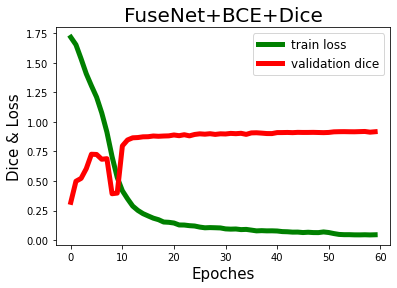

Average Test Dice = 0.9462


In [25]:
plt.plot(np.arange(60), np.array(train_loss_list), label='train loss', lw=5, c="green")
plt.plot(np.arange(60), np.array(val_dice_list), label='validation dice', lw=5, c="red")
plt.title("FuseNet+BCE+Dice", fontsize=20)
plt.legend(fontsize=12)
plt.xlabel("Epoches", fontsize=15)
plt.ylabel("Dice & Loss", fontsize=15)
plt.show()

print("Average Test Dice = %.4f" % (val_dice))

In [ ]:
# with h5py.File(os.path.join('.', 'data', path), 'r') as p_data:
#         for (patient_id,_) in p_data['ct_data'].items():
#             ct_data = np.array(p_data['ct_data'][patient_id])
#             label_data = np.array(p_data['label_data'][patient_id])
#             pet_data = np.array(p_data['pet_data'][patient_id])
#             valid_idx = np.unique(np.argwhere(label_data>0)[:,0])
#             for i in valid_idx:
#                 X_CT.append(standardize(ct_data[i]))
#                 label = cv2.resize(label_data[i], dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
#                 label[np.where(label>0)] = 1         
#                 Y.append(label)
#                 X_PET.append(standardize(pet_data[i]))